# Lecture 2: Introduction to Feature Engineering

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Setup

In [6]:
import numpy as np 
import pandas as pd
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import preprocessing
import zipfile
import io
import zipfile



In [8]:
articles = pd.read_csv('drive/MyDrive/ai_project_data/articles.csv.zip')
customers = pd.read_csv('drive/MyDrive/ai_project_data/customers.csv.zip')
# sample_submisison = pd.read_csv('drive/MyDrive/ai_project_data/sample_submission.csv')
transactions = pd.read_csv('drive/MyDrive/ai_project_data/transactions_train.csv.zip')

## The H&M Dataset

In [ ]:
# articles.info

In [ ]:
# customers.info()

In [ ]:
# transactions.info()

In [ ]:
# X = transactions.merge(customers, how='inner', on='customer_id')
# X = X.merge(articles, how='inner', on='article_id')

### Creating Samples 
If you would rather work with samples instead of the whole dataset (while prototyping your code). You can use the code below:

In [9]:
# Adapted from: https://www.kaggle.com/code/paweljankiewicz/hm-create-dataset-samples
# This extracts three sampled datasets, containing 0.1%, 1% and 5% of all users and their transactions, and the associated articles.
for sample_repr, sample in [("01", 0.001), ("1", 0.01), ("5", 0.05)]:
    print(sample)
    customers_sample = customers.sample(int(customers.shape[0]*sample), replace=False)
    customers_sample_ids = set(customers_sample["customer_id"])
    transactions_sample = transactions[transactions["customer_id"].isin(customers_sample_ids)]
    articles_sample_ids = set(transactions_sample["article_id"])
    articles_sample = articles[articles["article_id"].isin(articles_sample_ids)]
    customers_sample.to_csv(f"customers_sample{sample_repr}.csv.gz", index=False)
    transactions_sample.to_csv(f"transactions_sample{sample_repr}.csv.gz", index=False)
    articles_sample.to_csv(f"articles_sample{sample_repr}.csv.gz", index=False)

0.001
0.01
0.05


In [11]:
articles = pd.read_csv('articles_sample5.csv.gz')
customers = pd.read_csv('customers_sample5.csv.gz')
transactions = pd.read_csv('transactions_sample5.csv.gz')

In [ ]:
# customers_sample.info()

In [ ]:
# transactions_sample.info()

## A Simplified Task: Binary Classification

The task of predicting which 12 items users are most likely to buy in the next week is difficult to translate to a traditional classification machine learning setting. 
To obtain the 12 items a user is most likely to buy, we need to make predictions for all items (or the ones selected by a baseline) and select the 12 that have the highest predicted scores.

In this assignment, we'll consider a simplified task: Predict whether a user ordered a single item or not, based on the features of the user and the item. 
We provide a baseline logistic regression model below, but haven't done much feature preprocessing or engineering!
Initially, it is always best to focus your efforts on getting your features in the right shape and setting up the right validation scheme and baselines.
Once you are sure that your features add value and your validation scheme is correct, then you typically move on to trying more elaborate models.

### Creating the Dataset

In [83]:
# If you'd rather use a sample. Uncomment the following code:
# transactions = transactions_sample
# customers = customers_sample
# articles = articles_sample

In [84]:
transactions['ordered'] = 1

The problem setting is an example of a "PU learning" problem, i.e. only positives are labeled, everything else is unlabeled (and can be either positive or negative). 
Of course, we cannot train a classifier with just positive samples: The classifier will just learn that everything is positive.
Therefore, we need to manually generate negative samples.

Below, we use a simple random negative sampling strategy.
We want to create a balanced dataset, meaning that we have just as many positives as negatives.
This makes sure that the classifier will not benefit from predicting the positive/negative class more often than the other.
Realistically, the amount of positive samples is of course many times smaller than the amount of unlabeled, possibly negative instances.


If you want to try your hand at a more complex negative sampling strategy, you may want to check out this blog as a starting point: https://medium.com/mlearning-ai/overview-negative-sampling-on-recommendation-systems-230a051c6cd7.



In [85]:
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id,ordered
0,2018-09-20,003ac6eff3ca20cbe4e14a106a5e28b7551616005de8f9...,617322003,0.033881,1,1
1,2018-09-20,003ac6eff3ca20cbe4e14a106a5e28b7551616005de8f9...,617322003,0.018627,1,1
2,2018-09-20,003ac6eff3ca20cbe4e14a106a5e28b7551616005de8f9...,620405001,0.018627,1,1
3,2018-09-20,003ac6eff3ca20cbe4e14a106a5e28b7551616005de8f9...,678239001,0.025407,1,1
4,2018-09-20,00401a367c5ac085cb9d4b77c56f3edcabf25153615db9...,613456009,0.016932,2,1


In [86]:
# What's happening here? 
# We're creating negative samples. I.e. we're creating transactions that didn't actually occur.
# First, we need to know which interactions did occur:
positive_pairs = list(map(tuple, transactions[['customer_id', 'article_id']].drop_duplicates().values))

In [87]:
# Then we need to know what every synthetic transaction should contain: a date, a customer_id, an article_id, price, sales_channel_id. We will set ordered = 0, as these transactions didn't really occur.
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id,ordered
0,2018-09-20,003ac6eff3ca20cbe4e14a106a5e28b7551616005de8f9...,617322003,0.033881,1,1
1,2018-09-20,003ac6eff3ca20cbe4e14a106a5e28b7551616005de8f9...,617322003,0.018627,1,1
2,2018-09-20,003ac6eff3ca20cbe4e14a106a5e28b7551616005de8f9...,620405001,0.018627,1,1
3,2018-09-20,003ac6eff3ca20cbe4e14a106a5e28b7551616005de8f9...,678239001,0.025407,1,1
4,2018-09-20,00401a367c5ac085cb9d4b77c56f3edcabf25153615db9...,613456009,0.016932,2,1


In [88]:
# Extract real values
real_dates = transactions["t_dat"].unique()
real_customers = transactions["customer_id"].unique()
real_articles = transactions["article_id"].unique()
real_channels = transactions["sales_channel_id"].unique()
article_and_price = transactions[["article_id","price"]].drop_duplicates("article_id").set_index("article_id").squeeze()

In [89]:
# How many negatives do we need to sample?
num_neg_pos = transactions.shape[0]
print(num_neg_pos)

1587856


In [90]:
# Sampling negatives by selecting random users, articles, dates and sales channel:
# Note: This is quite naive. Some articles may not even have been available at the date we are sampling.
random.seed(42)

# Afterwards, we need to remove potential duplicates, so we'll sample too many.
num_neg_samples = int(num_neg_pos * 1.1)

# Sample each of the independent attributes.
neg_dates = np.random.choice(real_dates, size=num_neg_samples)
neg_articles = np.random.choice(real_articles, size=num_neg_samples)
neg_customers = np.random.choice(real_customers, size=num_neg_samples)
neg_channels = np.random.choice(real_channels, size=num_neg_samples)
ordered = np.array([0] * num_neg_samples)
# Assign to every article a real price.
neg_prices = article_and_price[neg_articles].values

In [91]:
neg_transactions = pd.DataFrame([neg_dates, neg_customers, neg_articles, neg_prices, neg_channels, ordered], index=transactions.columns).T

In [92]:
# Result:
neg_transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id,ordered
0,2019-08-11,2d1f0dd2f7d90a2561e37581ff1b8f30d8853cbbd8e36f...,620081008,0.025407,1,0
1,2019-05-25,ab0079bb476dc7e63056a5dfaf9eddb4b0f3db0a70fa43...,718543001,0.033881,2,0
2,2020-06-25,64757fae796f8a8993e20740a4d7cbe229839ce0333db9...,554867001,0.042356,1,0
3,2019-10-06,29c0b67358a1a6bca3c7760ac05c9026333ab1f638394d...,443860037,0.050831,1,0
4,2019-07-23,75044bd505b2587c7f8dbafa6371ac0d7dfaa65cbf3445...,605230002,0.040661,1,0


In [93]:
neg_transactions.shape

(1746641, 6)

In [94]:
# Remove random negative samples that actually coincide with positives
df = neg_transactions[
    ~neg_transactions.set_index(["customer_id", "article_id"]).index.isin(positive_pairs)
]

# Remove any excess
chosen_neg_transactions = df.sample(num_neg_pos)

In [95]:
# Concat the negative samples to the positive samples:
transactions = pd.concat([transactions, chosen_neg_transactions])
transactions = transactions.merge(customers, how="inner", on='customer_id')
transactions = transactions.merge(articles, how="inner", on='article_id')

In [96]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3175712 entries, 0 to 3175711
Data columns (total 36 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   t_dat                         object 
 1   customer_id                   object 
 2   article_id                    object 
 3   price                         object 
 4   sales_channel_id              object 
 5   ordered                       object 
 6   FN                            float64
 7   Active                        float64
 8   club_member_status            object 
 9   fashion_news_frequency        object 
 10  age                           float64
 11  postal_code                   object 
 12  product_code                  int64  
 13  prod_name                     object 
 14  product_type_no               int64  
 15  product_type_name             object 
 16  product_group_name            object 
 17  graphical_appearance_no       int64  
 18  graphical_appearance_n

### Basic Preprocessing
Some very basic preprocessing.

In [97]:
# I'm dropping a lot of columns, use them in your engineering tasks!
transactions_processed = transactions[['customer_id', 'age', 'article_id', 'sales_channel_id', 'price', 'ordered']].copy()
transactions_processed.head()

,customer_id,age,article_id,sales_channel_id,price,ordered
0,003ac6eff3ca20cbe4e14a106a5e28b7551616005de8f9...,27.0,617322003,1,0.033881,1
1,003ac6eff3ca20cbe4e14a106a5e28b7551616005de8f9...,27.0,617322003,1,0.018627,1
2,54c8227e06a0fcce2fdc7fb674b60e5c81697f12e781f5...,32.0,617322003,1,0.027102,1
3,84d5c6f9ebbacfd9c9257cfe4f4ed71793265b2e082b57...,29.0,617322003,2,0.022017,1
4,bf4d3ef3035d2164b6ec9402b37324303cb11cd51ce809...,62.0,617322003,2,0.022017,1


In [98]:
# Does it make sense to label encode?
# Label encoding the customer and article IDs:
customer_encoder = preprocessing.LabelEncoder()
article_encoder = preprocessing.LabelEncoder()

In [99]:
transactions_processed['customer_id'] = customer_encoder.fit_transform(transactions_processed['customer_id'])
transactions_processed['article_id'] = article_encoder.fit_transform(transactions_processed['article_id'])

In [100]:
# If you want to go back to the original encoding:
customer_encoder.inverse_transform([2])

array(['0002e6a17e3a75600888cac019846a600c9c6fe2bc1565613c6fa6c13f727071'],
      dtype=object)

In [101]:
transactions_processed.head()

,customer_id,age,article_id,sales_channel_id,price,ordered
0,57,27.0,16154,1,0.033881,1
1,57,27.0,16154,1,0.018627,1
2,22500,32.0,16154,1,0.027102,1
3,35361,29.0,16154,2,0.022017,1
4,51087,62.0,16154,2,0.022017,1


In [102]:
# Can you come up with a NaN strategy that makes sense for each column in the dataset?
# Imputing all NaN values with zeros:
transactions_processed = transactions_processed.fillna(0)
transactions_processed.isnull().values.any()

False

In [103]:
# Does it make sense to one-hot encode?
# One-hot-encoding sales_channel_id:
transactions_processed = pd.get_dummies(transactions_processed, columns=['sales_channel_id'])

In [104]:
transactions_processed.head()

,customer_id,age,article_id,price,ordered,sales_channel_id_1,sales_channel_id_2
0,57,27.0,16154,0.033881,1,1,0
1,57,27.0,16154,0.018627,1,1,0
2,22500,32.0,16154,0.027102,1,1,0
3,35361,29.0,16154,0.022017,1,0,1
4,51087,62.0,16154,0.022017,1,0,1


In [105]:
# Creating a Train / Test Split:
X_train, X_test, y_train, y_test = train_test_split(transactions_processed.drop('ordered', axis=1), transactions_processed['ordered'], test_size=0.10, random_state=42)

In [106]:
X_train.head()

,customer_id,age,article_id,price,sales_channel_id_1,sales_channel_id_2
590008,10288,26.0,41521,0.050831,0,1
2505359,11492,19.0,73763,0.013542,0,1
3081145,53802,36.0,48934,0.067780,0,1
795365,20685,28.0,66390,0.016932,0,1
2292090,267,49.0,60495,0.047441,0,1


In [107]:
y_train.head()

590008     0
2505359    0
3081145    1
795365     1
2292090    1
Name: ordered, dtype: int64

## Baseline Model

In [ ]:
# Will take a few minutes to run, if you're using the whole dataset:
# baseline = LogisticRegression(random_state=42)
# baseline = baseline.fit(X_train, y_train)

In [ ]:
# baseline.predict_proba(X_test)

In [ ]:
# y_test

In [ ]:
# Mean Accuracy:
# baseline.score(X_test, y_test)
# As you can seen, the accuracy is ~0.51. In other words, the classifier predicts correctly 51% of the time whether a customer did or din't buy an item.
# Can you improve this baseline logistic regression model by doing better preprocessing and generating new features?
# Also think about my steps! Did it make sense to include the article and customer ids? (And things like that)

In [ ]:
# Classification Metrics:
# predictions = baseline.predict(X_test)
# print(classification_report(y_test, predictions))

In [ ]:
# predictions

#Assignment EDA



##Customer_age

In [45]:
total_customers = customers.shape[0]
print(f"Amount of customers: {total_customers}")
print('\nBasic age information')
print(customers["age"].describe())



Amount of customers: 68599

Basic age information
count    67821.000000
mean        36.401351
std         14.321380
min         16.000000
25%         24.000000
50%         32.000000
75%         49.000000
max         95.000000
Name: age, dtype: float64


In [122]:
# customers with no age
customers_no_age = customers["age"].isna().sum()
print(f"Percent of users without an age: {customers_no_age/total_customers}")

Percent of users without an age: 0.01134127319640228


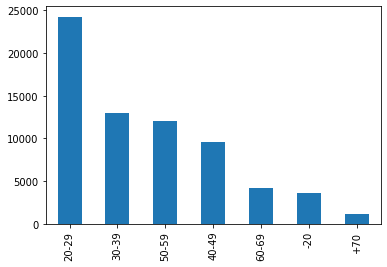

In [158]:
# categroized ages
age_df = customers[["customer_id", "age"]].copy()
bins= [15, 20,29,39,49, 59,69,100]
labels = ["-20", "20-29", "30-39", "40-49", "50-59", "60-69", "+70"]
age_df['age_cat'] = pd.cut(age_df['age'], bins=bins, labels=labels, right=False)
age_df["age_cat"].value_counts().plot.bar()

## customer FN

In [142]:
# amount of customers with FN == 1
customers["FN"].value_counts()


1.0    23804
Name: FN, dtype: int64

In [156]:
# Is FN always filled?
customers_no_fn = customers["FN"].isna().sum()
print(f"Percent of users without FN: {customers_no_fn/total_customers}")

Percent of users without FN: 0.6529978571116197


## Customer cub_member_status

In [144]:
# Values for club_member_status
customers["club_member_status"].value_counts()


ACTIVE        63645
PRE-CREATE     4635
LEFT CLUB        16
Name: club_member_status, dtype: int64

In [157]:
# Is club_member_status always filled?
customer_no_club = customers["club_member_status"].isna().sum()
print(f"Percent of users without club_member_status: {customer_no_club/total_customers}")

Percent of users without club_member_status: 0.004416974008367469


## postal code

In [146]:
# Length of postal codes?
customers["postal_code"].value_counts()

2c29ae653a9282cce4151bd87643c907644e09541abc28ae87dea0d1f6603b1c    6170
cc4ed85e30f4977dae47662ddc468cd2eec11472de6fac5ec985080fd92243c8      16
4d22901a97bd952bb92cdd31b38c39b41dd3250a735cabdfac1503eb405b807d      14
8537857094470e65f7a610a45fd3064b99dba724d18784bdec702a262a163171       9
45dc52765eb24eb8bc8a4a40a682d5e430aed58a9aba44e7f67d9516e54ba0d1       9
                                                                    ... 
219bc392bf7990bf270c3474eb78677df61b650c6eb8e65c72647c0b55bd3d23       1
13580ab98efb3d6581d6ad76ac5bba9a7865936ef61b22ca73148dda66568a69       1
88417ecb91f58818c798c4b41e3151d8c1385f87c4ce31eb3c90ee04688cdc75       1
72aa01b86f7928e0333937ca9e80f4062eed73933ea3d05a1fa0bf43697a3afa       1
7109c097142af116fa25095f90b57c6f992fd7177eb2556ef0de0da59e000c0c       1
Name: postal_code, Length: 55119, dtype: int64

In [152]:
# are all codes 64 integer hexidecimal
postal_codes = customers[["postal_code"]].copy()
postal_code_matches = postal_codes["postal_code"].str.fullmatch("^[a-f0-9]{64}$")
postal_codes[~postal_code_matches]

,postal_code


In [155]:
# are there customers with no postal code?
postal_codes["postal_code"].isna().sum()


0

In [176]:
# smallest article id
articles["article_id"].min()

108775015

##Article color

In [163]:
# how many colours are there and which one is most frequent?
product_colour = articles[["article_id", "prod_name", "colour_group_name", "colour_group_code"]].copy()
print(product_colour["colour_group_name"].describe())

count     76608
unique       50
top       Black
freq      17802
Name: colour_group_name, dtype: object


In [109]:
# does every article have a group_colour?
product_colour["colour_group_name"].isna().sum()

0

In [161]:
product_colour["colour_group_code"].isna().sum()

0

count     3175712
unique         50
top         Black
freq       919819
Name: colour_group_name, dtype: object


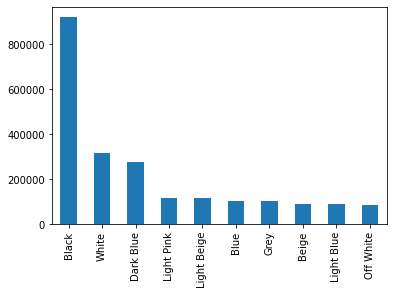

In [185]:
# which colour sells most?
transactions_colour = transactions[["article_id", "colour_group_name"]].copy()
print(transactions_colour["colour_group_name"].describe())
transactions_colour["colour_group_name"].value_counts()[:10].plot.bar()

In [191]:
# amount of sales that are black
transactions_black = transactions_colour[transactions_colour["colour_group_name"] == "Black"].shape[0]
print(f"Percentage of black article sales: {transactions_black/transactions_colour.shape[0]}%")

Percentage of black article sales: 0.2896418189054927%


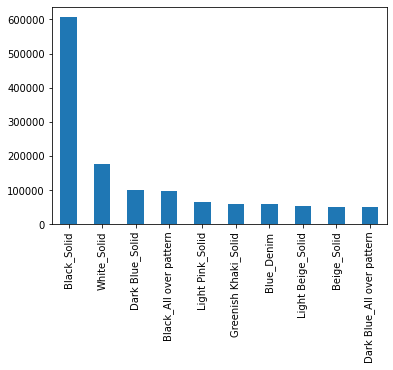

In [184]:
# what combination of colour and graphical appearance sells bests?
transactions_appearance = transactions[["article_id", "colour_group_name", "graphical_appearance_name"]].copy()
transactions_appearance["appearance"] = (transactions_appearance.colour_group_name.astype(str) + '_' + transactions_appearance.graphical_appearance_name.astype(str))
transactions_appearance["appearance"].value_counts()[:10].plot.bar()

In [193]:
# amount of sales that are black-solid
transactions_black_solid = transactions_appearance[transactions_appearance["appearance"] == "Black_Solid"].shape[0]
print(f"Percentage of black-solid article sales: {transactions_black_solid/transactions_colour.shape[0]}%")

Percentage of black-solid article sales: 0.19120153212885804%


##Article description

In [126]:
# does every article have a description?
article_descriptions = articles[["detail_desc"]].copy()
article_no_desc = article_descriptions["detail_desc"].isna().sum()
print(f"{article_no_desc} articles do not have a description")

296 articles do not have a description


## Article price

In [132]:
# does every article have a price?
articles_with_price = transactions[["article_id", "price"]].copy()
articles_with_price["price"].isna().sum()

0

In [178]:
articles_with_price["price"].max()

0.5067796610169492

## Assignment: Feature engineering
**TODO:** 
- In groups (of 2-3 students), think about (a few) features that can be engineered (preprocess and generate new features). Divide the work!
- Do these engineered features improve the baseline model?
- Add your thoughts & results to a slide deck for discussion next week (again, 1 slide per person).

# Color-product type #
Looks at the interaction between product type and the color of the item


In [ ]:
transactions_processed = transactions[['customer_id', 'age', 'article_id', 'sales_channel_id', 'price', 'ordered', 'colour_group_code', 'colour_group_name', 'product_type_name']]
transactions_processed.head()

,customer_id,age,article_id,sales_channel_id,price,ordered,colour_group_code,colour_group_name,product_type_name
0,017ddc94fee40ab9a24af073a4c69282b4c04e094d53a9...,28.0,496111020,1,0.033881,1,43,Dark Red,Sweater
1,3f5c5f836c9b82e18a84c37b10a986a51f8a6a3d250c10...,40.0,496111020,1,0.027102,1,43,Dark Red,Sweater
2,2b3ac8aafad8738d959cfbcc9c53e94d5de06345354965...,28.0,496111020,2,0.022017,1,43,Dark Red,Sweater
3,2b3ac8aafad8738d959cfbcc9c53e94d5de06345354965...,28.0,496111020,2,0.022017,1,43,Dark Red,Sweater
4,017ddc94fee40ab9a24af073a4c69282b4c04e094d53a9...,28.0,663007003,1,0.042356,1,9,Black,Sweater


In [ ]:
transactions_processed["colour_type"] = (transactions_processed.colour_group_name.astype(str) + '_' + transactions_processed.product_type_name.astype(str))
transactions_processed = transactions_processed.drop(['colour_group_name','product_type_name'], axis=1)
colour_type_encoder = preprocessing.LabelEncoder()
transactions_processed['colour_type'] = customer_encoder.fit_transform(transactions_processed['colour_type'])

transactions_processed.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,customer_id,age,article_id,sales_channel_id,price,ordered,colour_group_code,colour_type
0,017ddc94fee40ab9a24af073a4c69282b4c04e094d53a9...,28.0,496111020,1,0.033881,1,43,458
1,3f5c5f836c9b82e18a84c37b10a986a51f8a6a3d250c10...,40.0,496111020,1,0.027102,1,43,458
2,2b3ac8aafad8738d959cfbcc9c53e94d5de06345354965...,28.0,496111020,2,0.022017,1,43,458
3,2b3ac8aafad8738d959cfbcc9c53e94d5de06345354965...,28.0,496111020,2,0.022017,1,43,458
4,017ddc94fee40ab9a24af073a4c69282b4c04e094d53a9...,28.0,663007003,1,0.042356,1,9,118


In [ ]:



customer_encoder = preprocessing.LabelEncoder()
article_encoder = preprocessing.LabelEncoder()
transactions_processed['customer_id'] = customer_encoder.fit_transform(transactions_processed['customer_id'])
transactions_processed['article_id'] = article_encoder.fit_transform(transactions_processed['article_id'])

transactions_processed = transactions_processed.fillna(0)
transactions_processed.isnull().values.any()
transactions_processed.head()

,customer_id,age,article_id,sales_channel_id,price,ordered,colour_group_code,colour_type
0,8,28.0,866,1,0.033881,1,43,458
1,329,40.0,866,1,0.027102,1,43,458
2,223,28.0,866,2,0.022017,1,43,458
3,223,28.0,866,2,0.022017,1,43,458
4,8,28.0,4933,1,0.042356,1,9,118


In [ ]:
transactions_processed = pd.get_dummies(transactions_processed, columns=['sales_channel_id', 'colour_type'])
transactions_processed.head()

,customer_id,age,article_id,price,ordered,colour_group_code,sales_channel_id_1,sales_channel_id_2,colour_type_0,colour_type_1,...,colour_type_1391,colour_type_1392,colour_type_1393,colour_type_1394,colour_type_1395,colour_type_1396,colour_type_1397,colour_type_1398,colour_type_1399,colour_type_1400
0,8,28.0,866,0.033881,1,43,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,329,40.0,866,0.027102,1,43,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,223,28.0,866,0.022017,1,43,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,223,28.0,866,0.022017,1,43,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,28.0,4933,0.042356,1,9,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(transactions_processed.drop('ordered', axis=1), transactions_processed['ordered'], test_size=0.10, random_state=42)
baseline = LogisticRegression(random_state=42)
baseline = baseline.fit(X_train, y_train)
baseline.score(X_test, y_test)


0.6046511627906976

###Populartity
Looks at what items are sold within the last 4 months

In [ ]:
dated_transactions = transactions.loc[transactions["ordered"] == 1][["article_id", "t_dat"]]
dated_transactions["t_dat"] = pd.to_datetime(dated_transactions["t_dat"])
latest_date = dated_transactions["t_dat"].max()
dated_transactions["transaction_age_months"] = 12 * (latest_date.year - dated_transactions["t_dat"].dt.year) + (latest_date.month - dated_transactions["t_dat"].dt.month)
dated_transactions.head()

,article_id,t_dat,transaction_age_months
0,496111020,2018-09-20,24
1,496111020,2018-09-29,24
2,496111020,2019-01-03,20
3,496111020,2019-01-03,20
4,663007003,2018-09-24,24


Filter out sales that are older than 4 months. 

In [ ]:
popular_items = dated_transactions.loc[dated_transactions["transaction_age_months"] < 4]
popular_items = popular_items["article_id"].value_counts().rename_axis("article_id").reset_index(name="count")

In [ ]:
transactions_processed = transactions[['customer_id', 'age', 'article_id', 'sales_channel_id', 'price', 'ordered']].copy()
transactions_processed = transactions_processed.merge(popular_items, how="inner", on='article_id')
transactions_processed.head()

,customer_id,age,article_id,sales_channel_id,price,ordered,count
0,017ddc94fee40ab9a24af073a4c69282b4c04e094d53a9...,28.0,179123001,1,0.016932,1,1
1,017ddc94fee40ab9a24af073a4c69282b4c04e094d53a9...,28.0,179123001,1,0.016932,1,1
2,017ddc94fee40ab9a24af073a4c69282b4c04e094d53a9...,28.0,179123001,1,0.010153,1,1
3,74303ec6a09511c0d565953f448f64a07f769033df8f0a...,33.0,179123001,2,0.016932,1,1
4,1c58bc8c44ee0e1c203c7cadd1cbd234ead302850ae5a9...,38.0,179123001,1,0.01439,1,1


In [ ]:
customer_encoder = preprocessing.LabelEncoder()
article_encoder = preprocessing.LabelEncoder()
transactions_processed['customer_id'] = customer_encoder.fit_transform(transactions_processed['customer_id'])
transactions_processed['article_id'] = article_encoder.fit_transform(transactions_processed['article_id'])
transactions_processed = transactions_processed.fillna(0)
transactions_processed.isnull().values.any()
transactions_processed.head()

,customer_id,age,article_id,sales_channel_id,price,ordered,count
0,8,28.0,7,1,0.016932,1,1
1,8,28.0,7,1,0.016932,1,1
2,8,28.0,7,1,0.010153,1,1
3,595,33.0,7,2,0.016932,1,1
4,145,38.0,7,1,0.014390,1,1


In [ ]:
transactions_processed = pd.get_dummies(transactions_processed, columns=['sales_channel_id'])
transactions_processed.head()

,customer_id,age,article_id,price,ordered,count,sales_channel_id_1,sales_channel_id_2
0,8,28.0,7,0.016932,1,1,1,0
1,8,28.0,7,0.016932,1,1,1,0
2,8,28.0,7,0.010153,1,1,1,0
3,595,33.0,7,0.016932,1,1,0,1
4,145,38.0,7,0.014390,1,1,1,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(transactions_processed.drop('ordered', axis=1), transactions_processed['ordered'], test_size=0.10, random_state=42)
baseline = LogisticRegression(random_state=42)
baseline = baseline.fit(X_train, y_train)
baseline.score(X_test, y_test)

0.6298449612403101

#Popular product_type by colour
Looks at all items that were sold within the last 4 months and then
Looks at the interaction between product type and the color of the item

In [ ]:
transactions_processed = transactions[['customer_id', 'age', 'article_id', 'sales_channel_id', 'price', 'ordered', 'colour_group_code', 'colour_group_name', 'product_type_name']]
transactions_processed.head()

,customer_id,age,article_id,sales_channel_id,price,ordered,colour_group_code,colour_group_name,product_type_name
0,017ddc94fee40ab9a24af073a4c69282b4c04e094d53a9...,28.0,496111020,1,0.033881,1,43,Dark Red,Sweater
1,3f5c5f836c9b82e18a84c37b10a986a51f8a6a3d250c10...,40.0,496111020,1,0.027102,1,43,Dark Red,Sweater
2,2b3ac8aafad8738d959cfbcc9c53e94d5de06345354965...,28.0,496111020,2,0.022017,1,43,Dark Red,Sweater
3,2b3ac8aafad8738d959cfbcc9c53e94d5de06345354965...,28.0,496111020,2,0.022017,1,43,Dark Red,Sweater
4,017ddc94fee40ab9a24af073a4c69282b4c04e094d53a9...,28.0,663007003,1,0.042356,1,9,Black,Sweater


In [ ]:
transactions_processed = transactions_processed.merge(popular_items, how="inner", on='article_id')
transactions_processed["colour_type"] = (transactions_processed.colour_group_name.astype(str) + '_' + transactions_processed.product_type_name.astype(str))
transactions_processed = transactions_processed.drop(['colour_group_name','product_type_name'], axis=1)
colour_type_encoder = preprocessing.LabelEncoder()
transactions_processed['colour_type'] = customer_encoder.fit_transform(transactions_processed['colour_type'])
transactions_processed.head()

,customer_id,age,article_id,sales_channel_id,price,ordered,colour_group_code,count,colour_type
0,017ddc94fee40ab9a24af073a4c69282b4c04e094d53a9...,28.0,179123001,1,0.016932,1,9,1,65
1,017ddc94fee40ab9a24af073a4c69282b4c04e094d53a9...,28.0,179123001,1,0.016932,1,9,1,65
2,017ddc94fee40ab9a24af073a4c69282b4c04e094d53a9...,28.0,179123001,1,0.010153,1,9,1,65
3,74303ec6a09511c0d565953f448f64a07f769033df8f0a...,33.0,179123001,2,0.016932,1,9,1,65
4,1c58bc8c44ee0e1c203c7cadd1cbd234ead302850ae5a9...,38.0,179123001,1,0.01439,1,9,1,65


In [ ]:
customer_encoder = preprocessing.LabelEncoder()
article_encoder = preprocessing.LabelEncoder()
transactions_processed['customer_id'] = customer_encoder.fit_transform(transactions_processed['customer_id'])
transactions_processed['article_id'] = article_encoder.fit_transform(transactions_processed['article_id'])
transactions_processed = transactions_processed.fillna(0)
transactions_processed.isnull().values.any()
transactions_processed.head()

,customer_id,age,article_id,sales_channel_id,price,ordered,colour_group_code,count,colour_type
0,8,28.0,7,1,0.016932,1,9,1,65
1,8,28.0,7,1,0.016932,1,9,1,65
2,8,28.0,7,1,0.010153,1,9,1,65
3,595,33.0,7,2,0.016932,1,9,1,65
4,145,38.0,7,1,0.014390,1,9,1,65


In [ ]:
transactions_processed = pd.get_dummies(transactions_processed, columns=['sales_channel_id', 'colour_type'])
transactions_processed.head()

,customer_id,age,article_id,price,ordered,colour_group_code,count,sales_channel_id_1,sales_channel_id_2,colour_type_0,...,colour_type_728,colour_type_729,colour_type_730,colour_type_731,colour_type_732,colour_type_733,colour_type_734,colour_type_735,colour_type_736,colour_type_737
0,8,28.0,7,0.016932,1,9,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,28.0,7,0.016932,1,9,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8,28.0,7,0.010153,1,9,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,595,33.0,7,0.016932,1,9,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,145,38.0,7,0.014390,1,9,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(transactions_processed.drop('ordered', axis=1), transactions_processed['ordered'], test_size=0.10, random_state=42)
baseline = LogisticRegression(random_state=42)
baseline = baseline.fit(X_train, y_train)
baseline.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.6253229974160207